# Exploratory Data Analysis

The objective of this notebook is to identify key drivers of electricity prices and formulate testable hypotheses based on supply-demand dynamics by doing the following:
1. Identify trends and periodic behaviour
2. Study correlations between variables
3. Formulate hypotheses

## 1. Identify trends and periodic behaviour

### 1.1 Load datasets

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"))
df_weather = pd.read_csv(os.path.join(base_dir, "weather_data.csv"))

# Make sure dataset timestamps are pandas.Timestamp objects
df_electricity['startTime'] = pd.to_datetime(df_electricity['startTime'])
df_electricity['settlementDate'] = pd.to_datetime(df_electricity['settlementDate'])
df_weather['ob_time'] = pd.to_datetime(df_weather['ob_time'])

print(f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB")
print(f"Weather data memory usage: {np.sum(df_weather.memory_usage()) / 10**6} MB")

print("\nElectricity data columns:\n", df_electricity.columns)
print("\nWeather data columns:\n", df_weather.columns)

Electricity data memory usage: 9.082892 MB
Weather data memory usage: 5.886628 MB

Electricity data columns:
 Index(['settlementDate', 'settlementPeriod', 'startTime', 'BIOMASS', 'GAS',
       'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER', 'INDO',
       'ITSO', 'marketIndexPrice', 'marketIndexTradingVolume',
       'naturalGasPrice'],
      dtype='object')

Weather data columns:
 Index(['ob_time', 'wind_speed', 'wind_direction', 'visibility',
       'air_temperature', 'glbl_irad_amt', 'location'],
      dtype='object')


In [26]:
df_electricity.head()

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,INDO,ITSO,marketIndexPrice,marketIndexTradingVolume,naturalGasPrice
0,2021-01-01,1,2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30,19.499
1,2021-01-01,2,2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40,19.499
2,2021-01-01,3,2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00,19.499
3,2021-01-01,4,2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35,19.499
4,2021-01-01,5,2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40,19.499


In [27]:
df_weather.head()

,ob_time,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
0,2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
1,2021-01-01 01:00:00,1.028,340.0,350.0,0.2,0.0,Heathrow
2,2021-01-01 02:00:00,1.028,320.0,400.0,0.2,0.0,Heathrow
3,2021-01-01 03:00:00,2.056,280.0,320.0,0.0,0.0,Heathrow
4,2021-01-01 04:00:00,2.056,290.0,250.0,-0.2,0.0,Heathrow


### 1.2 Electricity prices

Plot a seasonal decomposition of daily mean market index prices:

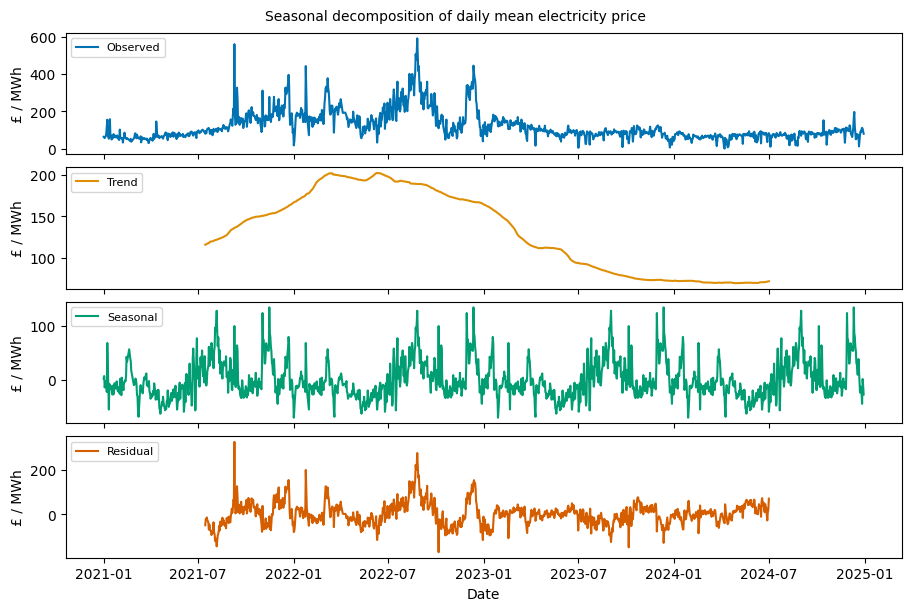

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily_mip = df_electricity.groupby('settlementDate')['marketIndexPrice'].mean()
decomposition = seasonal_decompose(daily_mip, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(9, 6), layout='constrained', sharex=True)
colors = sns.color_palette("colorblind", 4)
axes[0].plot(decomposition.observed.index, decomposition.observed.values, label='Observed', color=colors[0])
axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color=colors[1])
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', color=colors[2])
axes[3].plot(decomposition.resid.index, decomposition.resid.values, label='Residual', color=colors[3])
axes[3].set_xlabel('Date', fontsize=10)
for ax in axes:
    ax.set_ylabel('£ / MWh', fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
fig.suptitle('Seasonal decomposition of daily mean electricity price', fontsize=10)
plt.show()

*Comments:*

There are clear seasonal fluctuations, with lower prices during the summers and higher prices during the winters. In addition, we see a peak in the price trend, which might be attributed to higher natural gas prices around the same period (we will confirm this later).

Plot price histogram:

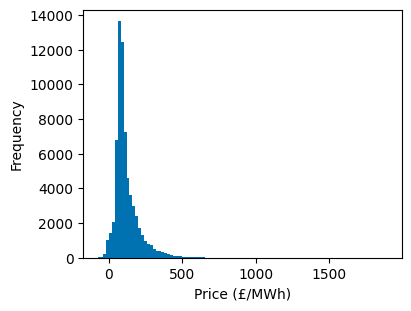

In [29]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.hist(df_electricity['marketIndexPrice'], bins=100)
ax.set_xlabel('Price (£/MWh)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
plt.show()

Let's investigate monthly, weekly, daily and intraday price patterns:

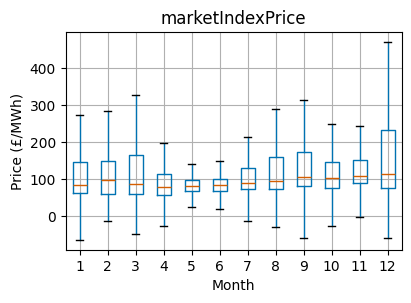

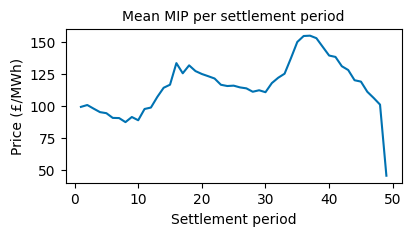

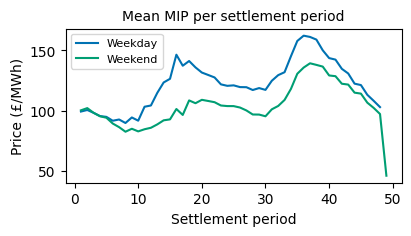

In [30]:
# Box plot by month (not showing outlier points)
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
df_electricity['month'] = df_electricity['settlementDate'].dt.month
df_electricity.boxplot(column='marketIndexPrice', by='month', ax=ax, sym='')
ax.set_xlabel('Month', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
fig.suptitle('')
plt.show()

# Average price by settlement period
sp_avg = df_electricity.groupby(df_electricity['settlementPeriod'])['marketIndexPrice'].mean()
fig, ax = plt.subplots(figsize=(16/4, 9/4), layout='constrained')
ax.plot(sp_avg.index, sp_avg.values)
ax.set_xlabel('Settlement period', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title('Mean MIP per settlement period', fontsize=10)
plt.show()

# Average price by weekday
df_electricity['day_of_week'] = df_electricity['settlementDate'].dt.dayofweek
df_electricity['is_weekend'] = df_electricity['day_of_week'] >= 5
fig, ax = plt.subplots(figsize=(16/4, 9/4), layout='constrained')
for weekend, group in df_electricity.groupby('is_weekend'):
    hourly = group.groupby(group['settlementPeriod'])['marketIndexPrice'].mean()
    label = 'Weekend' if weekend else 'Weekday'
    ax.plot(hourly.index, hourly.values, label=label)
ax.legend(loc='best', fontsize=8)
ax.set_xlabel('Settlement period', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title('Mean MIP per settlement period', fontsize=10)
plt.show()

### 1.3 Natural gas prices

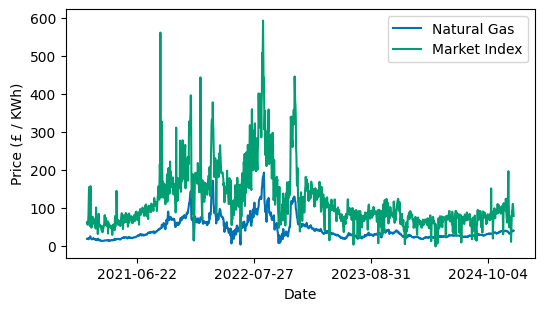

In [31]:
from matplotlib.ticker import MaxNLocator

# drop duplicates
gas_prices = df_electricity.groupby(df_electricity['settlementDate'].dt.date).first()['naturalGasPrice']

fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='constrained')
ax.plot(gas_prices.index, gas_prices.values, label='Natural Gas')
ax.plot(daily_mip.index, daily_mip.values, label='Market Index')
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Price (£ / KWh)', fontsize=10)
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=5))
plt.show()

### 1.4 Electricity generation

Let's break down the electricity generation sources:

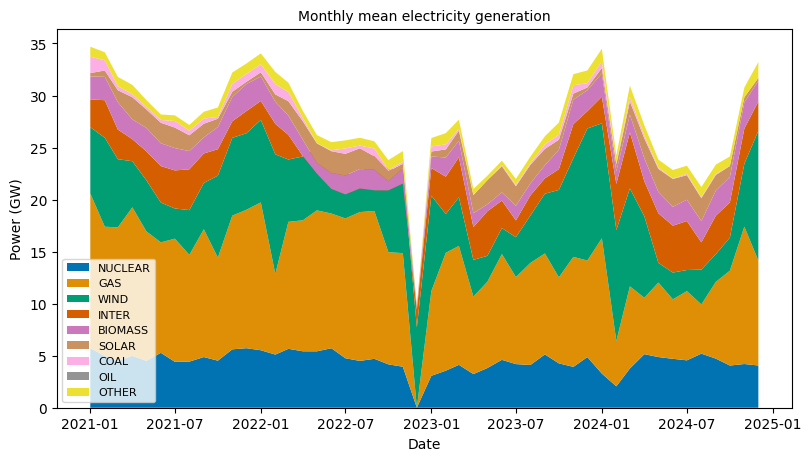

In [32]:
from matplotlib.dates import DateFormatter
import datetime

generation_types = ['NUCLEAR', 'GAS', 'WIND', 'INTER', 'BIOMASS', 'SOLAR', 'COAL', 'OIL', 'OTHER']

# Group by year-month and take mean
df_electricity['year_month'] = df_electricity['settlementDate'].dt.to_period('M')
monthly_generation_by_type = df_electricity.groupby('year_month')[generation_types].mean()

# Convert period index back to datetime for plotting
monthly_generation_by_type.index = monthly_generation_by_type.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16/2, 9/2), layout='constrained')
ax.set_title('Monthly mean electricity generation', fontsize=10)
colors = sns.color_palette("colorblind", len(generation_types))
xdata = monthly_generation_by_type.index
ydata = [monthly_generation_by_type[gt] / 1000 for gt in generation_types]
ax.stackplot(xdata, ydata, labels=generation_types, colors=colors)
ax.legend(fontsize=8, loc='best')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Changed format to show year-month
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Power (GW)', fontsize=10)
plt.show()

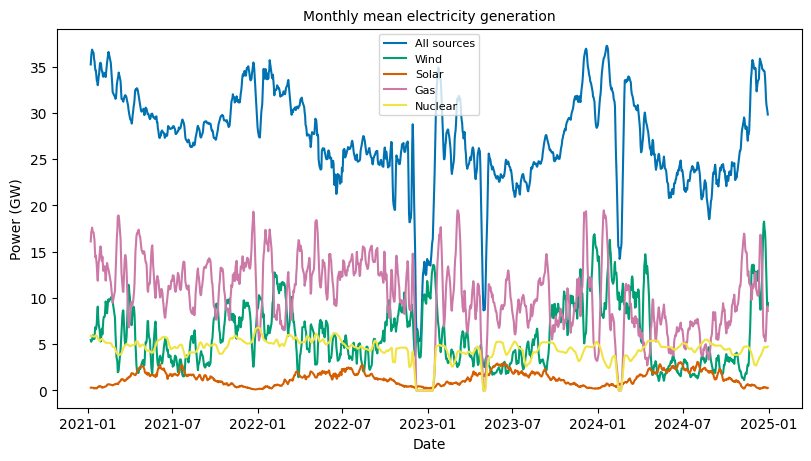

In [33]:
# compute total generation
generation_by_type = df_electricity[generation_types]
df_electricity['generationTotal'] = generation_by_type.sum(axis=1)

# take 7-day rolling average
cols = generation_types + ['generationTotal']
daily_generation = df_electricity.groupby('settlementDate')[cols].mean()
rolling_generation = daily_generation.rolling(window=7).mean()

# plot
fig, ax = plt.subplots(figsize=(16/2, 9/2), layout='constrained')
ax.plot(rolling_generation['generationTotal'].index, rolling_generation['generationTotal'].values / 1000, label='All sources')
ax.plot(rolling_generation['WIND'].index, rolling_generation['WIND'].values / 1000, label='Wind')
ax.plot(rolling_generation['SOLAR'].index, rolling_generation['SOLAR'].values / 1000, label='Solar')
ax.plot(rolling_generation['GAS'].index, rolling_generation['GAS'].values / 1000, label='Gas')
ax.plot(rolling_generation['NUCLEAR'].index, rolling_generation['NUCLEAR'].values / 1000, label='Nuclear')
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Power (GW)', fontsize=10)
ax.legend(fontsize=8, loc='best')
ax.set_title('Monthly mean electricity generation', fontsize=10)
plt.show()

Plot electricity generation breakdown for the first week in October 2023:

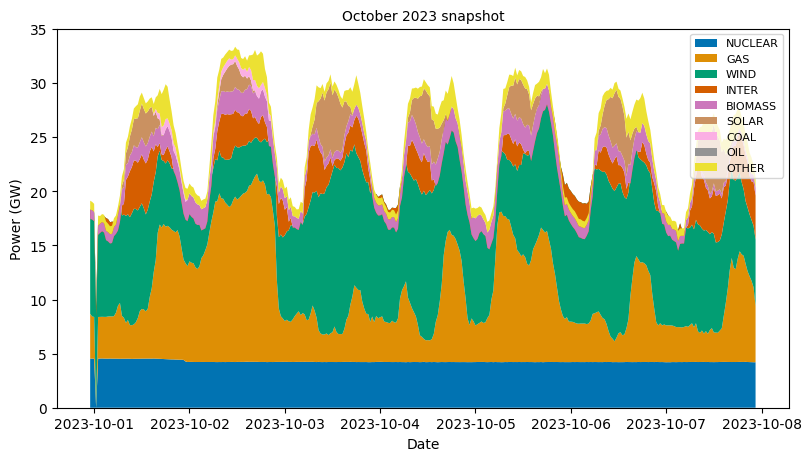

In [34]:
# select smaller date range for plotting
start_date = pd.to_datetime("2023-10-01") 
end_date = pd.to_datetime("2023-10-07")
mask = (df_electricity['settlementDate'] >= start_date) & (df_electricity['settlementDate'] <= end_date)
df_elec_filtered = df_electricity.loc[mask].copy()

time = df_elec_filtered['startTime']
generation_by_type = df_elec_filtered[generation_types]

fig, ax = plt.subplots(figsize=(16/2, 9/2), layout='constrained')
colors = sns.color_palette("colorblind", len(generation_types))
ax.stackplot(time, [generation_by_type[gt] / 1000 for gt in generation_types], labels=generation_types, colors=colors)
ax.legend(fontsize=8, loc='upper right')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Power (GW)', fontsize=10)
ax.set_title('October 2023 snapshot', fontsize=10)
plt.show()

Let's plot MIP, NGP and generation over a shorter time period (first week in October 2023):

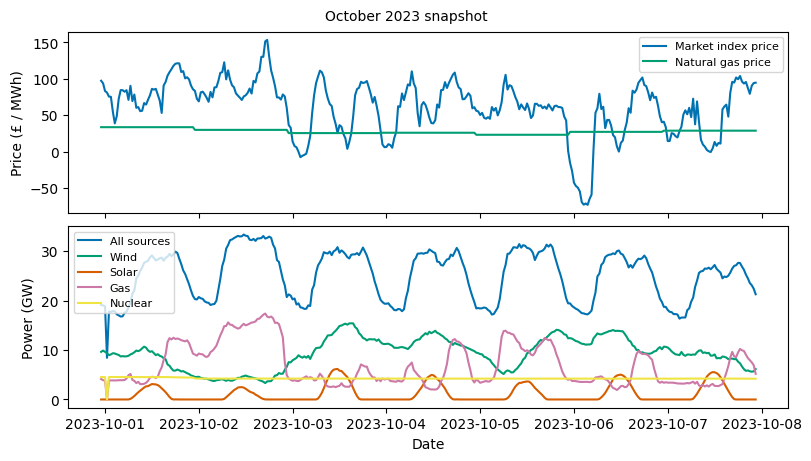

In [35]:
# select smaller date range
start_date = pd.to_datetime("2023-10-01") 
end_date = pd.to_datetime("2023-10-07")
mask = (df_electricity['settlementDate'] >= start_date) & (df_electricity['settlementDate'] <= end_date)
df = df_electricity.loc[mask]
df = df.set_index('startTime')
MIP = df['marketIndexPrice']
NGP = df['naturalGasPrice']
generation = df['generationTotal'] / 1000  # rescale to GW
wind = df['WIND'] / 1000  # rescale to GW
solar = df['SOLAR'] / 1000  # rescale to GW
gas = df['GAS'] / 1000  # rescale to GW
nuclear = df['NUCLEAR'] / 1000  # rescale to GW

colors = sns.color_palette("colorblind", 7)

# Plot 1: Prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16/2, 9/2), layout='constrained', sharex=True)
ax1.plot(MIP.index, MIP, label='Market index price')
ax1.plot(NGP.index, NGP, label='Natural gas price')
# ax.set_xlabel('Date', fontsize=10)
ax1.set_ylabel('Price (£ / MWh)', fontsize=10)
ax1.legend(fontsize=8, loc='best')

# Plot 2: Generation
ax2.plot(generation.index, generation, label='All sources')
ax2.plot(wind.index, wind, label='Wind')
ax2.plot(solar.index, solar, label='Solar')
ax2.plot(gas.index, gas, label='Gas')
ax2.plot(nuclear.index, nuclear, label='Nuclear')
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Power (GW)', fontsize=10)
ax2.legend(fontsize=8, loc='best')
fig.suptitle('October 2023 snapshot', fontsize=10)
plt.show()

*Comments:*

- Nuclear, gas and wind make up the majority of the energy generation
- Nuclear generation is very stable
- There are large, daily fluctuations in energy generation
- Energy from interconnectors is mostly positive, indicating that imports are larger than exports
- Solar generation coincides with early peak hours
- Oil generation is neglibible
- There are clearly seasonal patterns in both wind and solar generation (more solar during summers, more wind during winters).
- There are some anomalies in the generation data around the end of 2022, spring 2023 and the beginning of 2024 that indicate incorrect measurement or missing values for non-renewable energy sources.

In [36]:
# drop oil generation from data
df_electricity.drop(columns='OIL', inplace=True)
generation_types.remove('OIL')

### 1.5 Weather patterns

In [37]:
df_weather.columns

Index(['ob_time', 'wind_speed', 'wind_direction', 'visibility',
       'air_temperature', 'glbl_irad_amt', 'location'],
      dtype='object')

In [38]:
# Average over locations for each timestamp
df_avg_locations = (
    df_weather.groupby('ob_time')
      .mean(numeric_only=True)
      .reset_index() 
)

# Average over locations and dates
df_avg_locations_dates = df_weather.groupby(df_weather['ob_time'].dt.date).mean(numeric_only=True).reset_index()
df_avg_locations_dates.rename(columns={'ob_time': 'date'}, inplace=True)
df_avg_locations_dates.set_index('date', inplace=True)

Plot seasonal decomposition of air temperature, wind speed and irradiation averaged over the locations and days:

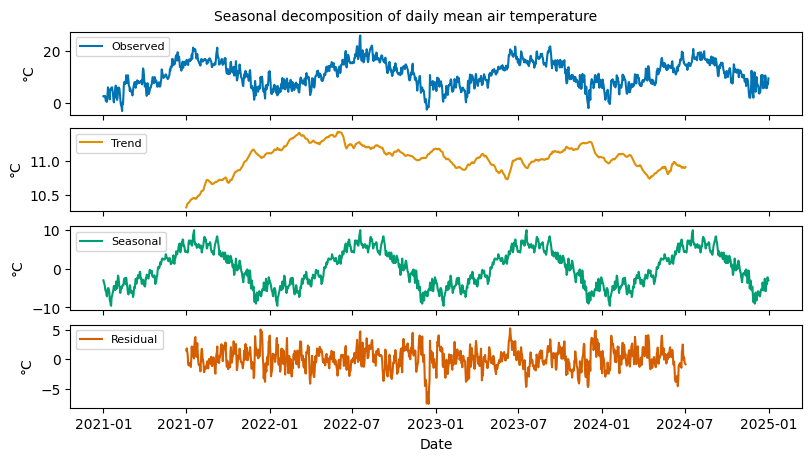

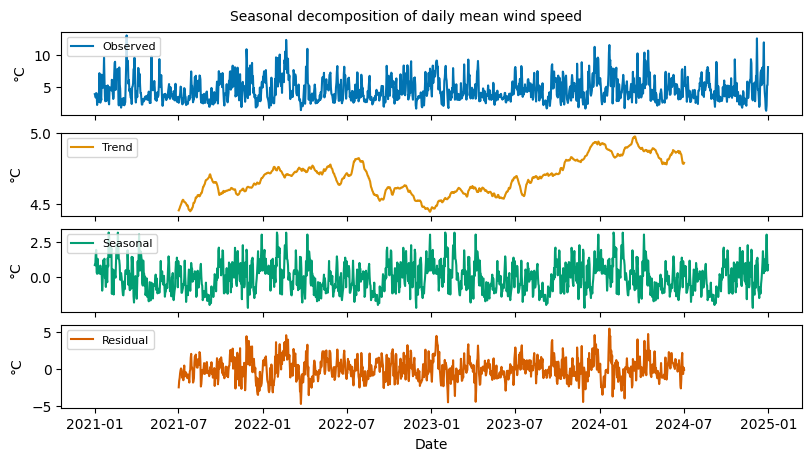

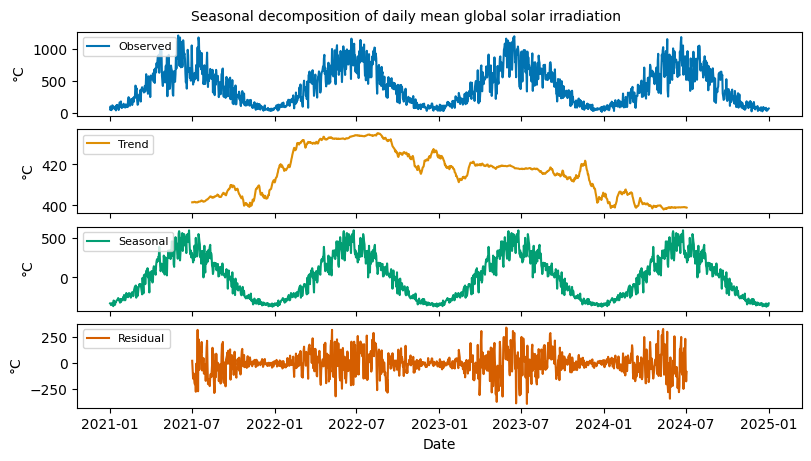

In [39]:
# Decompose air temperature
daily_temp = df_avg_locations_dates['air_temperature']
decomposition = seasonal_decompose(daily_temp, model='additive', period=365)

# Plot air temperature
fig, axes = plt.subplots(4, 1, figsize=(16/2, 9/2), layout='constrained', sharex=True)
colors = sns.color_palette("colorblind", 4)
axes[0].plot(decomposition.observed.index, decomposition.observed.values, label='Observed', color=colors[0])
axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color=colors[1])
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', color=colors[2])
axes[3].plot(decomposition.resid.index, decomposition.resid.values, label='Residual', color=colors[3])
axes[3].set_xlabel('Date', fontsize=10)
for ax in axes:
    ax.set_ylabel("$\\degree \\mathrm{C}$", fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
fig.suptitle('Seasonal decomposition of daily mean air temperature', fontsize=10)
plt.show()

# Decompose wind speed
daily_wind = df_avg_locations_dates['wind_speed']
decomposition = seasonal_decompose(daily_wind, model='additive', period=365)

# Plot wind speed
fig, axes = plt.subplots(4, 1, figsize=(16/2, 9/2), layout='constrained', sharex=True)
colors = sns.color_palette("colorblind", 4)
axes[0].plot(decomposition.observed.index, decomposition.observed.values, label='Observed', color=colors[0])
axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color=colors[1])
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', color=colors[2])
axes[3].plot(decomposition.resid.index, decomposition.resid.values, label='Residual', color=colors[3])
axes[3].set_xlabel('Date', fontsize=10)
for ax in axes:
    ax.set_ylabel("$\\degree \\mathrm{C}$", fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
fig.suptitle('Seasonal decomposition of daily mean wind speed', fontsize=10)
plt.show()

# Decompose solar irradiation
daily_irrad = df_avg_locations_dates['glbl_irad_amt']
decomposition = seasonal_decompose(daily_irrad, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(16/2, 9/2), layout='constrained', sharex=True)
colors = sns.color_palette("colorblind", 4)
axes[0].plot(decomposition.observed.index, decomposition.observed.values, label='Observed', color=colors[0])
axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color=colors[1])
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', color=colors[2])
axes[3].plot(decomposition.resid.index, decomposition.resid.values, label='Residual', color=colors[3])
axes[3].set_xlabel('Date', fontsize=10)
for ax in axes:
    ax.set_ylabel("$\\degree \\mathrm{C}$", fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
fig.suptitle('Seasonal decomposition of daily mean global solar irradiation', fontsize=10)
plt.show()

## 2. Correlations between variables

Market index price autocorrelation:

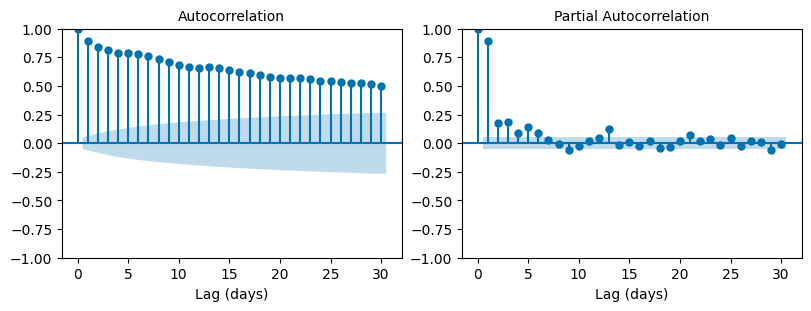

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

daily_prices = df_electricity.groupby('settlementDate')['marketIndexPrice'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
plot_acf(daily_prices, lags=30, ax=axes[0])
plot_pacf(daily_prices, lags=30, ax=axes[1])
axes[0].set_title('Autocorrelation', fontsize=10)
axes[1].set_title('Partial Autocorrelation', fontsize=10)
axes[0].set_xlabel('Lag (days)')
axes[1].set_xlabel('Lag (days)')
plt.show()

In [63]:
# Prepare weather data to match electricity time stamps
df_electricity['startTime'] = pd.to_datetime(df_electricity['startTime']).dt.tz_localize(None)
df_avg_locations['ob_time'] = pd.to_datetime(df_avg_locations['ob_time']).dt.tz_localize(None)
df = df_avg_locations.rename(columns={'ob_time': 'startTime'})

# Merge
df = df_electricity.merge(df, on='startTime', how='inner')

# Compute correlations
mip_correlations = {}
mip_correlations['naturalGasPrice'] = df[['naturalGasPrice', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['windGen'] = df[['WIND', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['solarGen'] = df[['SOLAR', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['nuclearGen'] = df[['NUCLEAR', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['interconnect'] = df[['INTER', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['bioGen'] = df[['BIOMASS', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['airTemp'] = df[['air_temperature', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['windSpeed'] = df[['wind_speed', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['windDirection'] = df[['wind_direction', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['irradiation'] = df[['glbl_irad_amt', 'marketIndexPrice']].corr().iloc[0,1]
mip_correlations['visibility'] = df[['visibility', 'marketIndexPrice']].corr().iloc[0,1]

In [64]:
print(f"MIP Correlations:\n{20*'-'}")
for (key, val) in mip_correlations.items():
    print(f'{key}: {val:.3f}')

MIP Correlations:
--------------------
naturalGasPrice: 0.808
windGen: -0.158
solarGen: -0.070
nuclearGen: -0.011
interconnect: -0.190
bioGen: 0.064
airTemp: 0.006
windSpeed: -0.192
windDirection: -0.050
irradiation: -0.042
visibility: -0.004


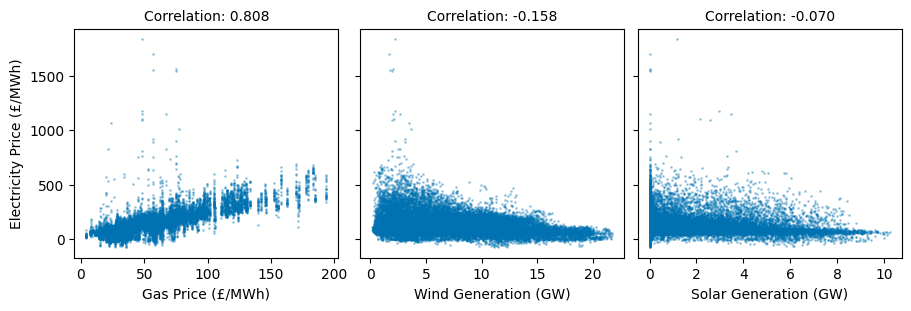

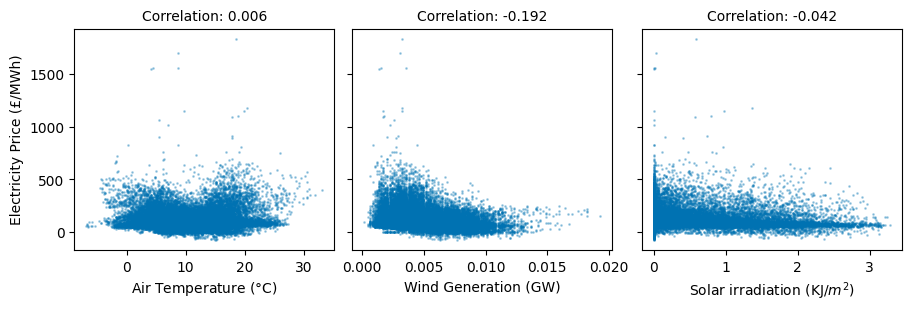

In [66]:
# Plot some relationships:
fig, axes = plt.subplots(1, 3, layout='constrained', figsize=(9, 3), sharey=True)
# Gas price
axes[0].scatter(df['naturalGasPrice'], df['marketIndexPrice'], alpha=0.3, s=1)
axes[0].set_xlabel('Gas Price (£/MWh)', fontsize=10)
axes[0].set_ylabel('Electricity Price (£/MWh)', fontsize=10)
axes[0].set_title(f'Correlation: {mip_correlations['naturalGasPrice']:.3f}', fontsize=10)
# Wind generation
axes[1].scatter(df['WIND'] / 1000, df['marketIndexPrice'], alpha=0.3, s=1)
axes[1].set_xlabel('Wind Generation (GW)', fontsize=10)
axes[1].set_title(f'Correlation: {mip_correlations['windGen']:.3f}', fontsize=10)
# Solar generation
axes[2].scatter(df['SOLAR'] / 1000, df['marketIndexPrice'], alpha=0.3, s=1)
axes[2].set_xlabel('Solar Generation (GW)', fontsize=10)
axes[2].set_title(f'Correlation: {mip_correlations['solarGen']:.3f}', fontsize=10)
plt.show()

fig, axes = plt.subplots(1, 3, layout='constrained', figsize=(9, 3), sharey=True)
# Temperature
axes[0].scatter(df['air_temperature'], df['marketIndexPrice'], alpha=0.3, s=1)
axes[0].set_xlabel('Air Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
axes[0].set_ylabel('Electricity Price (£/MWh)', fontsize=10)
axes[0].set_title(f'Correlation: {mip_correlations['airTemp']:.3f}', fontsize=10)
# Wind speed
axes[1].scatter(df['wind_speed'] / 1000, df['marketIndexPrice'], alpha=0.3, s=1)
axes[1].set_xlabel('Wind Generation (GW)', fontsize=10)
axes[1].set_title(f'Correlation: {mip_correlations['windSpeed']:.3f}', fontsize=10)
# Solar irradiation
axes[2].scatter(df['glbl_irad_amt'] / 1000, df['marketIndexPrice'], alpha=0.3, s=1)
axes[2].set_xlabel('Solar irradiation ($\\mathrm{KJ}/m^2$)', fontsize=10)
axes[2].set_title(f'Correlation: {mip_correlations['irradiation']:.3f}', fontsize=10)
plt.show()

*Comments:*

Temperature and MIP correlation is slightly U-shaped, which might indicate a quadratic relationship.

## 3. Hypotheses

**Supply hypothesis:** Gas prices and wind speed are significant supply-side drivers of electricity prices.

**Demand hypothesis:** Temperature and temporal patterns (seasons, time of day, etc.) are significant demand-side drivers of electricity prices.